In [1]:
"""
Part 1: Data preprocessing
"""

'\nPart 1: Data preprocessing\n'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Forex predict using long short term memory')\
        .config('hive.metastore.uris', 'thrift://10.121.31.83:9083')\
        .enableHiveSupport()\
        .getOrCreate()

In [18]:
spark.sql("show databases").show()
spark.sql("use forex")
spark.sql("show tables").show()

+------------------+
|      databaseName|
+------------------+
|           default|
|        first_work|
|             forex|
|information_schema|
|         movie_len|
|               sys|
|              test|
|      titanic_data|
+------------------+

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
|   forex|20120102_eurusd|      false|
|   forex|  201201_eurusd|      false|
|   forex| 2012_m1_eurusd|      false|
|   forex|  201902_eurusd|      false|
|   forex|    2019_eurusd|      false|
|   forex|    2019_minute|      false|
+--------+---------------+-----------+



In [20]:
spark_df = spark.sql("select * from 2012_m1_eurusd")
spark_df.show()

+----------+-----+--------+--------+-------+---------+------+
|      date| time|open_bid|high_bid|low_bid|close_bid|volume|
+----------+-----+--------+--------+-------+---------+------+
|2012.01.02|02:00| 1.29324| 1.29381|1.29324|  1.29332|     0|
|2012.01.02|02:01| 1.29326| 1.29345|1.29275|  1.29341|     0|
|2012.01.02|02:02| 1.29342| 1.29344|1.29341|  1.29343|     0|
|2012.01.02|02:03| 1.29342| 1.29342|1.29335|  1.29336|     0|
|2012.01.02|02:04| 1.29324| 1.29347| 1.2932|  1.29346|     0|
|2012.01.02|02:05| 1.29354| 1.29415|1.29354|  1.29392|     0|
|2012.01.02|02:06| 1.29393| 1.29442|1.29391|   1.2943|     0|
|2012.01.02|02:07| 1.29429| 1.29429|1.29395|  1.29395|     0|
|2012.01.02|02:08| 1.29396| 1.29408|1.29395|  1.29407|     0|
|2012.01.02|02:09| 1.29406| 1.29434|1.29401|   1.2942|     0|
|2012.01.02|02:10| 1.29418| 1.29436|1.29408|  1.29425|     0|
|2012.01.02|02:11| 1.29423| 1.29438|1.29423|  1.29433|     0|
|2012.01.02|02:12| 1.29442| 1.29447|1.29401|  1.29432|     0|
|2012.01

In [21]:
spark_df.count()

372161

In [22]:
df = spark_df.toPandas()

In [6]:
# get the open price (column _c2)
training_set = df.iloc[:35000,2:3].values

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
X_train = []
y_train = []

In [69]:
len = training_set_scaled.size

In [12]:
# Creating a data structure with 60 timesteps and 1 output
for i in range(60, len):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

TypeError: range() integer end argument expected, got builtin_function_or_method.

In [13]:
# Reshaping -> why we need reshape?
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

AttributeError: 'list' object has no attribute 'shape'

In [62]:
"""
Part 2: Building the NN
"""

'\nPart 2: Building the NN\n'

In [63]:
# import keras library: -> need to understand these library usage
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [76]:
# Initialising the RNN
regressor = Sequential()

In [77]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [78]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [79]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [80]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [81]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [82]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [84]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34940/34940 [==============================] - 316s 9ms/step - loss: 0.0015
Epoch 2/20
34940/34940 [==============================] - 318s 9ms/step - loss: 0.0011
Epoch 3/20
34940/34940 [==============================] - 320s 9ms/step - loss: 8.8984e-04
Epoch 4/20
34940/34940 [==============================] - 321s 9ms/step - loss: 7.6234e-04
Epoch 5/20
34940/34940 [==============================] - 318s 9ms/step - loss: 7.2129e-04
Epoch 6/20
34940/34940 [==============================] - 319s 9ms/step - loss: 6.9587e-04
Epoch 7/20
34940/34940 [==============================] - 314s 9ms/step - loss: 6.6869e-04
Epoch 8/20
34940/34940 [==============================] - 317s 9ms/step - loss: 6.5765e-04
Epoch 9/20
34940/34940 [==============================] - 316s 9ms/step - loss: 6.6647e-04
Epoch 10/20
34940/34940 [==============================] - 317s 9ms/step - loss: 6.3479e-04
Epoch 11/20
34940/34940 [==============================] - 318s 9ms/step - loss: 6.2480e-04
Epoch

In [85]:
"""
Part 3: Making the predictions and visualising the results
"""

'\nPart 3: Making the predictions and visualising the results\n'

In [96]:
real_stock_price = df.iloc[35000:37000,2:3].values

In [111]:
inputs = sc.transform(real_stock_price)

In [100]:
training_set_scaled

array([[0.50551804],
       [0.50584747],
       [0.50848295],
       ...,
       [0.80678636],
       [0.80975128],
       [0.8118926 ]])

In [112]:
test_len = inputs.size

In [113]:
test_len

2000

In [114]:
X_test = []

In [115]:
for i in range(60, test_len):
    X_test.append(inputs[i-60:i, 0])

In [116]:
X_test = np.array(X_test)

In [117]:
X_test.shape

(1940, 60)

In [118]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [119]:
predicted_stock_price = regressor.predict(X_test)

In [120]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [122]:
predicted_stock_price.size

1940

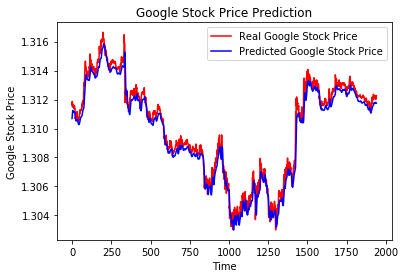

In [123]:
# Visualising the results
plt.plot(real_stock_price[60:], color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()